# <center><span style="font-family: ClearSans-Bold, sans-serif; color:#8027eaff">Understanding LGD Risk</span></center>

<span style="font-family: ClearSans, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [ ]:
%%capture
!pip install pandas numpy matplotlib scikit-learn scipy lightgbm

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'

### Dataset
[Source of processed Lending Club data](https://github.com/shawn-y-sun/Credit_Risk_Model_LoanDefaults)

<span style="font-family: ClearSans, sans-serif; color:navyblue">Inputs to the recovery cash-flows calculation:</h3>
<ul style="font-family: ClearSans, sans-serif;">
    <li><b>int_rate:</b> loan interest rate</li>
    <li><b>MRP:</b> maximum recovery period (36 months)</li>
    <li><b>recoveries:</b> the recoveries obtained from collateral</li>
    <li><b>collection_recovery_fee:</b> the total fees obtained from the obligor for collateral recovery</li>
    <li><b>total_rec_prncp:</b> the total received principal to date</li>
    <li><b>total_rec_int:</b> the total received interest to date</li>
    <li><b>total_rec_late_fee:</b> the total received from late fees</li>
    <li><b>funded_amnt:</b> the total amount of the loan</li>
</ul>


In [3]:
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

In [28]:
loan_data = pd.read_csv('loan_data_defaults.csv', index_col=0, low_memory=False)
loan_data = loan_data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [29]:
# Discounting of recovery cash-flows

# interest rate
loan_data['int_rate'] = loan_data['int_rate'] / 100
# maximum recovery period (assumed to be 3 years)
MRP = 36

# Calculate discount factor
loan_data['discount_factor'] = (1 + loan_data['int_rate']/12) ** MRP

# Recovery cash-flows
loan_data['recovery_cf'] = (loan_data['recoveries'] \
                            + loan_data['collection_recovery_fee'] \
                            + loan_data['total_rec_prncp'] \
                            + loan_data['total_rec_int'] \
                            + loan_data['total_rec_late_fee'])

# discounting recovery cash-flows
loan_data['recovery_cf_disc'] = loan_data['recovery_cf'] / loan_data['discount_factor']

# Realized LGD calculation
loan_data['LGD'] = (loan_data['funded_amnt'] - loan_data['recovery_cf_disc']) / loan_data['funded_amnt']

# flooring and capping
loan_data['LGD'] = np.where(loan_data['LGD'] < 0, 0,
         (np.where((loan_data['LGD'] > 1) | (loan_data['LGD'].isnull()), 1, loan_data['LGD'])))

In [31]:
# current account utilization
loan_data['utilization'] = loan_data['revol_bal'].astype(float) / loan_data['total_rev_hi_lim'].astype(float) 
loan_data['utilization'] = np.where(loan_data['utilization'] > 1, 1, loan_data['utilization'])

In [32]:
lgd_cols = ['funded_amnt',
            'total_pymnt',
            'last_pymnt_amnt',
            'zip_code',
            'grade',
            'utilization',
            'annual_inc',
            'purpose',
            'inq_last_6mths',
            'mths_since_last_delinq',
            'dti',
            'LGD']

loan_data_lgd = loan_data[lgd_cols].copy()

loan_data_lgd.rename({
    'total_pymnt': 'payments_received',
    'funded_amnt': 'ead',
    'LGD': 'lgd',
}, axis=1, inplace=True)

In [33]:
features_testing = [
    'ead',
    'payments_received',
    'last_pymnt_amnt',
    'zip_code', 
    'grade',
    'utilization',
    'annual_inc',
    'purpose',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'dti']

In [34]:
# features and target
X = loan_data_lgd[features_testing + ['lgd']].copy()
y = X.pop('lgd')

# sampling (train / test)
ix_train, ix_test = train_test_split(
    X.index,
    test_size=0.3, 
    random_state=24)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}")

Train: 30,265
Test: 12,971


### Approach 1: Linear regression

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [36]:
features_lr = ['payments_received',
               'last_pymnt_amnt',
               'zip_code',
               'grade',
               'utilization',
               'annual_inc',
               'purpose',
               'inq_last_6mths',
               'mths_since_last_delinq',
               'dti']

In [37]:
# specify categorical features
feats_cat = X[features_lr].select_dtypes(include=[object]).columns

In [39]:
# one-hot encoding categorical features
transformer = ColumnTransformer(
    transformers=[('OneHotEncoder', 
                   OneHotEncoder(drop='first', handle_unknown='ignore'), feats_cat)], 
    remainder='passthrough', 
    verbose_feature_names_out=False)

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
linreg = LinearRegression()

sk_lr_model = Pipeline(steps=[("transformer", transformer),
                                  ("imputer", imputer),
                                  ("regressor", linreg)])

# training the model
sk_lr_model.fit(X.loc[ix_train][features_lr], y.loc[ix_train])

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['zip_code', 'grade', 'purpose'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor', LinearRegression())])

In [40]:
# predict on original data
X['lgd_pred_lr'] = sk_lr_model.predict(X)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
# Rank-correlation
spearmanr(y.loc[ix_test],
          X.loc[ix_test]['lgd_pred_lr'])[0]

0.6966000996027512

### Approach 2: WOE logistic regression

#### Dataset preparation

In [44]:
import uuid
from optbinning import BinningProcess, OptimalBinning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [45]:
def duplicate_dataset(df, id_col):
    lgd_woe = []
    for i in df[id_col].unique():
        mask = (df[id_col] == i)
        df_bad = df[mask].loc[df[mask].index.repeat(df[mask].bads)]
        df_bad['is_default'] = 1
        df_good = df[mask].loc[df[mask].index.repeat(df[mask].goods)]
        df_good['is_default'] = 0
        df_all = pd.concat([df_bad, df_good], axis=0)
        lgd_woe.append(df_all)
    lgd_woe = pd.concat(lgd_woe)
    return(lgd_woe)

In [46]:
# create unique identifier and prepare goods/bads columns
loan_data_lgd['id'] = [uuid.uuid4() for _ in range(len(loan_data_lgd.index))]
loan_data_lgd['bads'] = (loan_data_lgd['lgd'] * 100).round().astype(int)
loan_data_lgd['goods'] = 100 - loan_data_lgd['bads']

In [47]:
# create a duplicated dataset
start_time = time.time()

loan_data_lgd_woe = duplicate_dataset(loan_data_lgd, "id")

execution_time = time.time() - start_time
print(f"Training time: {execution_time:.4f} seconds")

print(f"Original sample size: {len(loan_data_lgd):,.0f}")
print(f"Duplicated sample size: {len(loan_data_lgd_woe):,.0f}")

Training time: 156.0275 seconds
Original sample size: 43,236
Duplicated sample size: 4,323,600


In [48]:
features_woe = ['payments_received',
                'zip_code',
                'grade',
                'utilization',
                'annual_inc',
                'purpose',
                'dti']

In [49]:
# mirroring statsmodels logistic regression
lr_params = {
          "fit_intercept": True,
          "penalty": "l2",
          "random_state": 72,
          "solver": "liblinear",
          }

In [50]:
# economic relationships with defaults for WOE
binning_fit_params_woe = {
    "payments_received":
        {
            "monotonic_trend": "descending", 
            "solver": "cp",
        },
    "last_pymnt_amnt":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp",
        },
    "utilization":
        {
            "monotonic_trend": "descending", 
            "solver": "cp", 
        },
    "annual_inc":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "inq_last_6mths":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "mths_since_last_delinq":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "dti":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "purpose":
        {
            "dtype": "categorical",
        },
    "zip_code":
        {
            "dtype": "categorical",
        },
    "grade": {
        "dtype": "categorical",
        "user_splits": np.array([
            ["A", "B", "C"],
             ["D"],
             ["E"],
             ["F"],
             ["G"]
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
            True,
            True,
            True,
        ],
    },
}

def create_woe_pipeline(X_train, X_test, y_train, y_test):
    # transformer
    binning_process = BinningProcess(
        variable_names=list(X_train.columns),
        binning_fit_params=binning_fit_params_woe,
    )
    
    # estimator
    logreg = LogisticRegression(**lr_params)
    
    pipeline = Pipeline(steps=[("binning_process", binning_process), 
                               ("regressor", logreg)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    gini = roc_auc_score(y_test, y_pred)*2-1
    print(f"Gini : {gini:.2%}")

    return pipeline

In [51]:
X_tr = loan_data_lgd_woe[features_woe]
y_tr = loan_data_lgd_woe['is_default'].values

# splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True, random_state=62)

ob_woe_lr = create_woe_pipeline(X_train, X_test, y_train, y_test)

# print coefficients
display(pd.DataFrame(
    list(zip(features_woe, ob_woe_lr[1].coef_.ravel())),
    columns=['feature', 'coefficient']
    ))

Gini : 32.71%


,feature,coefficient
0,payments_received,-1.274302
1,zip_code,-0.522429
2,grade,-1.177020
3,utilization,-1.189172
4,annual_inc,-6.766136
5,purpose,-0.133794
6,dti,-0.906099


In [52]:
# predict on original data
X['lgd_pred'] = ob_woe_lr.predict_proba(X)[:,1]

In [53]:
# Rank-correlation
spearmanr(y.loc[ix_test],
          X.loc[ix_test]['lgd_pred'])[0]

0.7319348676846269

In [54]:
# look at realized and predicted LGDs
pd.concat([X.loc[ix_test]['lgd_pred'][0:10], y.loc[ix_test][0:10]], axis=1)

,lgd_pred,lgd
451500,0.580022,0.637201
126629,0.686485,0.624482
145969,0.733064,0.854756
41532,0.690708,0.455335
31724,0.386335,0.523480
132983,0.739450,0.426498
269407,0.772521,0.832594
23485,0.683037,0.810674
409919,0.653674,0.701861
124237,0.927090,0.958019


### Approach 3: Boosting

In [55]:
import lightgbm as lgb

In [56]:
# preprocess categorical feats for lgb
for c in feats_cat:
    X[c] = X[c].astype('category')

In [57]:
features_lgb = ['payments_received',
                'last_pymnt_amnt',
                'zip_code',
                'grade',
                'utilization',
                'annual_inc',
                'purpose',
                'inq_last_6mths',
                'mths_since_last_delinq',
                'dti']

In [58]:
# set monotonic constraints
mono_df = pd.DataFrame(
    pd.concat([X[features_lgb].drop(columns=feats_cat), y], axis=1).corr(
    method='spearman').unstack()['lgd'], columns=['trend']).reset_index()
mono_df = mono_df[mono_df['index'] != 'lgd'].copy()

mono_constraints = {'feature':[], 'constraint':[]}

for i in mono_df['index'].unique():
    if mono_df[mono_df['index'] == i]['trend'].item() < 0:
        mono_constraints['feature'].append(i)
        mono_constraints['constraint'].append(-1.0)
    else:
        mono_constraints['feature'].append(i)
        mono_constraints['constraint'].append(1.0)

In [59]:
# reorder columns
features_lgb = list(mono_constraints['feature']) + list(feats_cat)
# assign constraints to categorical variables
mc = mono_constraints['constraint'].copy() + [0] * len(list(feats_cat))

In [60]:
params = {
    "objective": "regression",
    "num_leaves": 10,
    "n_estimators": 100,
    "learning_rate": 0.1,
    "verbosity": -1,
    "monotone_constraints": mc,
    "seed": 62,
}

classifier = lgb.LGBMRegressor(**params)
classifier.fit(
    X.loc[ix_train][features_lgb], 
    y.loc[ix_train].to_numpy().ravel(),
    categorical_feature=list(feats_cat))

/opt/homebrew/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(monotone_constraints=[-1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0, 0,
                                    0],
              num_leaves=10, objective='regression', seed=62, verbosity=-1)

In [61]:
X['lgd_pred_lgb'] = classifier.predict(X[features_lgb])

In [62]:
spearmanr(y.loc[ix_test], 
          X.loc[ix_test]['lgd_pred_lgb'])[0]

0.8955208616208512

In [63]:
pd.concat([X.loc[ix_test]['lgd_pred_lgb'][0:10], y.loc[ix_test][0:10]], axis=1)

,lgd_pred_lgb,lgd
451500,0.725663,0.637201
126629,0.665047,0.624482
145969,0.783075,0.854756
41532,0.605209,0.455335
31724,0.582117,0.523480
132983,0.669543,0.426498
269407,0.818046,0.832594
23485,0.748658,0.810674
409919,0.684211,0.701861
124237,0.978953,0.958019


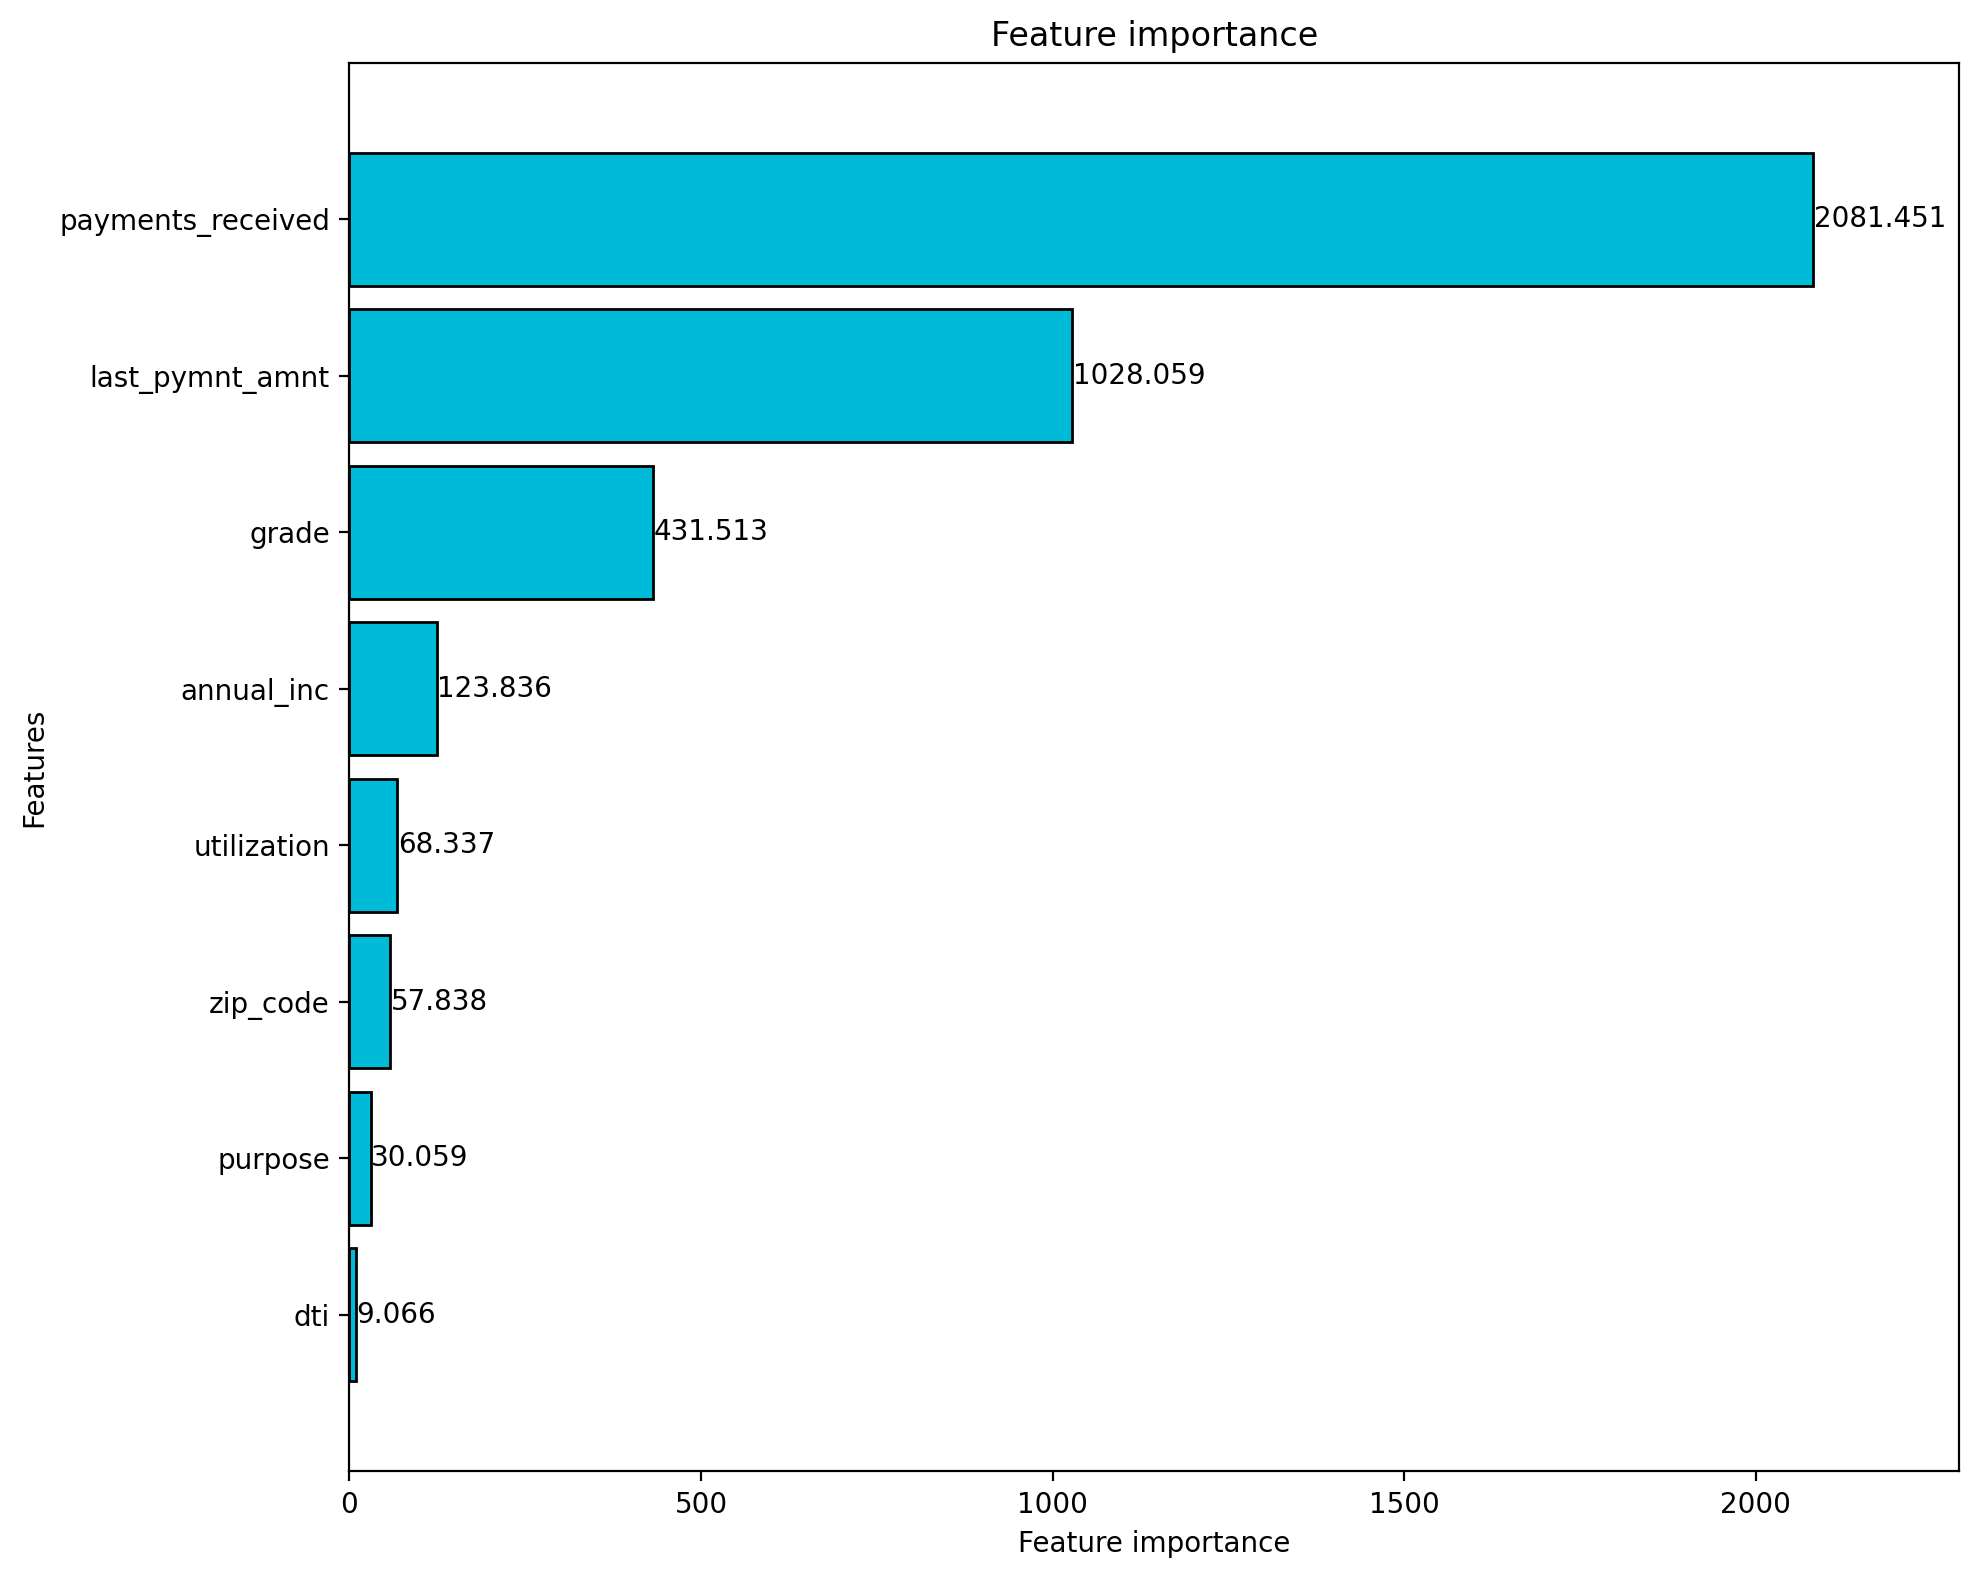

In [64]:
lgb.plot_importance(classifier, 
                    importance_type='gain', 
                    height=0.85, 
                    color='#00BBD7',
                    edgecolor='black', 
                    grid=False,
                    figsize=(10,8))
plt.tight_layout()
plt.show()

### LGD discrimination testing

In [65]:
import numpy as np
import pandas as pd

def clar(y: np.ndarray, X: np.ndarray) -> float:
    """Calculate Cumulative LGD Accuracy Ratio (CLAR).

    CLAR measures the ability of predicted LGD categories to discriminate
    realized LGD values according to Ozdemir and Miu 2009.

    Args:
        y (np.ndarray): Vector of realized LGD values
        X (np.ndarray): Vector of predicted LGD values

    Returns:
            Tuple[float, np.ndarray, np.ndarray]:
                - CLAR value for the predicted and realized LGD categories
                - Share of observations as a numpy array
                - Cumulative share of correctly assigned LGD values as a numpy array

    Raises:
        ValueError: If either 'X' or 'y' contains NA values
        ValueError: If 'X' and 'y' have different lengths

    References:
        Ozdemir, B., Miu, P., 2009. Basel II Implementation. A Guide to
        Developing and Validating a Compliant Internal Risk Rating System.
        McGraw-Hill, USA.
    """

    if any(pd.isna(X)) or any(pd.isna(y)):
        raise ValueError("Both 'X' and 'y' must not contain NA values")
    
    if len(X) != len(y):
        raise ValueError("Both 'X' and 'y' must be of the same length")
    
    nx = len(X)
    classes = sorted(list(set(X).union(set(y))), reverse=True)
    num = [sum(X == cls) for cls in classes]
    cnum = np.cumsum(num)
    index = np.argsort(X)[::-1]
    X = np.array(X)[index]
    y = np.array(y)[index]
    corr = np.zeros(len(classes))
    
    for i in range(len(classes) - 1):
        if cnum[i] > 0:
            corr[i] = np.sum(y[:cnum[i]] >= classes[i])
    
    corr /= nx
    corr[-1] = 1
    obs = cnum / nx
    
    res = obs[0] * corr[0] / 2
    for i in range(1, len(corr)):
        res += (corr[i] - corr[i-1]) * (obs[i] - obs[i-1]) / 2 + (obs[i] - obs[i-1]) * corr[i-1]
    
    return res * 2, obs, corr

In [70]:
clar_lr = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred_lr'])[0]
clar_woe = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred'])[0]
clar_lr_lgb = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred_lgb'])[0]

In [69]:
print(f"Linear regression CLAR: {clar_lr:.2%}")
print(f"WOE LR CLAR: {clar_woe:.2%}")
print(f"LGBM CLAR: {clar_lr_lgb:.2%}")

Linear regression CLAR: 82.40%
WOE LR CLAR: 84.58%
LGBM CLAR: 92.10%


#### Visualize discrimination (CLAR curve)

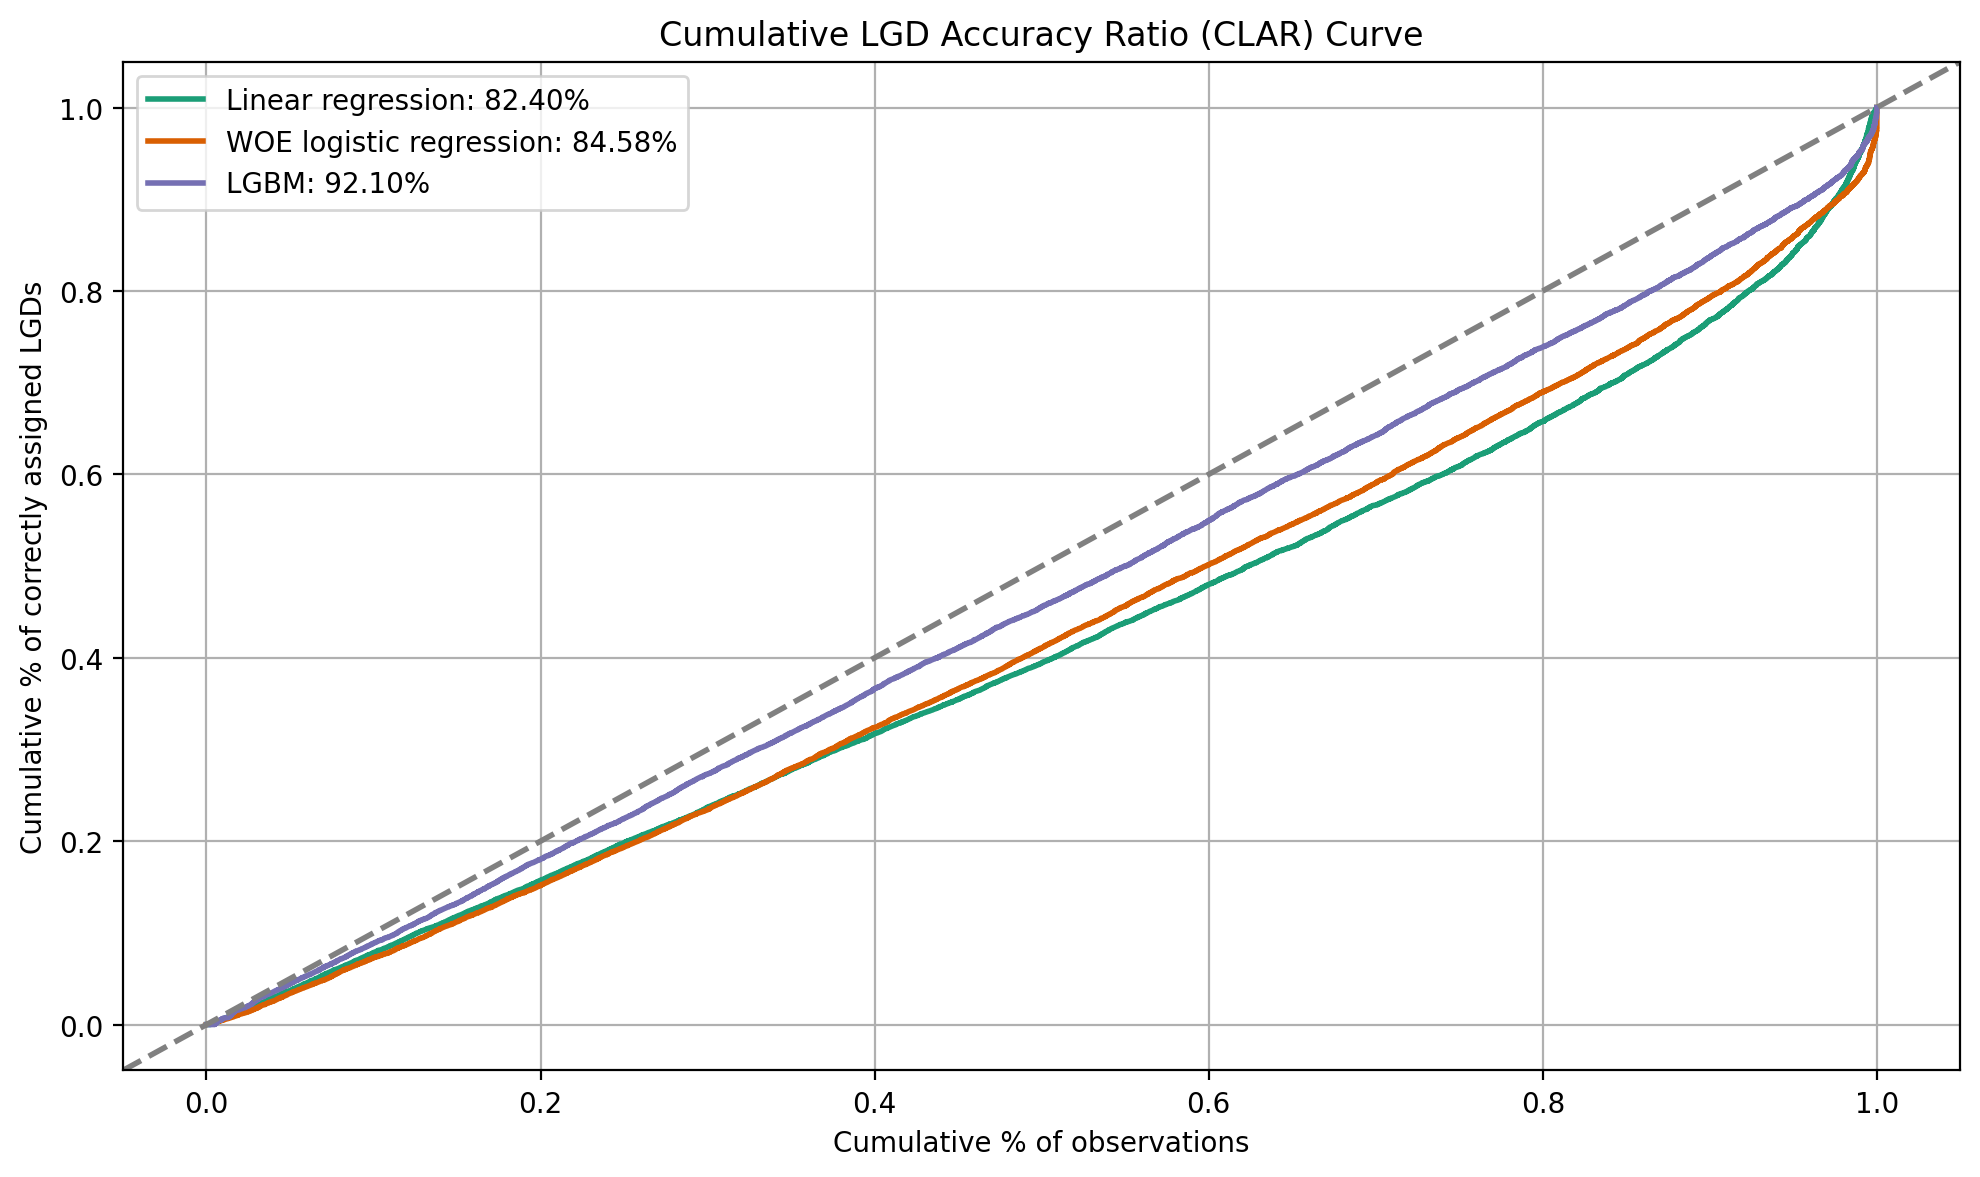

In [72]:
columns = ['lgd_pred_lr', 'lgd_pred', 'lgd_pred_lgb']
labels = ['Linear regression', 'WOE logistic regression', 'LGBM']
data = {}

cmap = plt.get_cmap('Dark2')

# create inputs for the plot
for column in columns:
    clar_value, obs, corr  = clar(y.loc[ix_test].values, X.loc[ix_test, column].values)
    data[column] = {'obs': obs, 'corr': corr, 'clar_value': clar_value}

# create a dataframe
df = pd.DataFrame(data)
num_colors = len(df.columns)

# Plot predictions on a CLAR curve
plt.figure(figsize=(10, 6))

for i, column in enumerate(df.columns):
    color = cmap(i % num_colors)
    plt.plot(df[column]['obs'], 
             df[column]['corr'], 
             color=color,
             linewidth=2,
             label=f"{labels[i]}: {df[column]['clar_value']:.2%}")

# Add a horizontal line representing perfect discrimination
plt.axline((0, 0), slope=1, linestyle='--', linewidth=2, color='gray')

plt.xlabel("Cumulative % of observations")
plt.ylabel("Cumulative % of correctly assigned LGDs")
plt.title("Cumulative LGD Accuracy Ratio (CLAR) Curve")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('CLAR_curves.png', dpi=600)
plt.show()